# Training

### Dataset

In [2]:
# Import all necessary libraries and mount to Google Drive
import pandas as pd
import numpy as np
from google.colab import drive
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
import pickle
import seaborn as sb
from sklearn.metrics import confusion_matrix
import matplotlib as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# Load dataset subset with 5 emojis
df = pd.read_csv("/content/gdrive/My Drive/CS3244/Final/Updated/full_train_preprocessed_subset.csv")
df = df.drop(columns=['Unnamed: 0'])

df_val = pd.read_csv("/content/gdrive/My Drive/CS3244/Final/Updated/full_val_preprocessed_subset.csv")
df_val = df_val.drop(columns=['Unnamed: 0'])

df_test = pd.read_csv("/content/gdrive/My Drive/CS3244/Final/Updated/full_test_preprocessed_subset.csv")
df_test = df_test.drop(columns=['Unnamed: 0'])

df

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,annotations,text,hashtag,tokens,upper_case,num_digits,num_hashtags,num_words,average_word_length,positive,neutral,negative,compound,label
0,1384,Nobody go to Walmart in sulphur,NaN,"['nobody', 'go', 'walmart', 'sulphur']",2,0,1,6,4.333333,0.0,1.0,0.0,0.0,2
1,1384,@emberlhamon @MLidak welcome to the ugly club!!,NaN,"['welcome', 'ugly', 'club']",2,0,1,8,5.125000,0.0,1.0,0.0,0.0,2
2,1384,getting to help coach jr high,NaN,"['getting', 'help', 'coach', 'jr', 'high']",0,0,1,6,4.000000,0.0,1.0,0.0,0.0,2
3,1384,Yo Gotti and Black Youngsta on stage we all th...,NaN,"['yo', 'gotti', 'black', 'youngsta', 'stage', ...",4,0,1,13,3.692308,0.0,1.0,0.0,0.0,2
4,1384,@spenceribarra just making sure I haven't been...,NaN,"['making', 'sure', 'havent', 'replaced']",1,0,1,9,5.333333,0.0,1.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133994,1392,Agape Worshippers their voices are so angelic...,NaN,"['agape', 'worshipper', 'voice', 'angelic', 'g...",3,0,1,12,5.000000,0.0,1.0,0.0,0.0,3
133995,1392,@abike \nHe's a cutie,NaN,"['he', 'cutie']",1,0,1,5,3.400000,0.0,1.0,0.0,0.0,3
133996,1392,@Americooligan thanks,NaN,['thanks'],1,0,1,3,6.666667,0.0,1.0,0.0,0.0,3
133997,1392,Ari's mom braided my hair,NaN,"['aris', 'mom', 'braided', 'hair']",1,0,1,6,3.500000,0.0,1.0,0.0,0.0,3


### Glove

In [4]:
# Convert Twitter GloVe to vector
glove2vector = {}

with open(f'/content/gdrive/MyDrive/CS3244/Glove Embeddings/glove.twitter.27B.100d.txt', 'rb') as f:
  for l in f:
    line = l.decode().split()
    word = line[0]
    vect = np.array(line[1:]).astype(np.float)
    glove2vector[word] = vect 

len(glove2vector)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


1193515

In [5]:
# Clean data 
from ast import literal_eval
import re

def clean_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

def join_text(x):
  return clean_text(x)
  
df["text_clean"] = df["text"].apply(lambda x: join_text(x))
df_val["text_clean"] = df_val["text"].apply(lambda x: join_text(x))
df_test["text_clean"] = df_test["text"].apply(lambda x: join_text(x))

In [6]:
X_train, y_train, X_val, y_val, X_test, y_test = df["text_clean"], df["label"], df_val["text_clean"], df_val["label"], df_test["text_clean"], df_test["label"]

In [7]:
# Pad data
def transform(X):
  return np.array([
            np.mean([glove2vector[w] for w in words if w in glove2vector]
                   or [np.zeros(100)], axis=0) for words in X])

train_padded = transform(X_train)
val_padded = transform(X_val)
test_padded = transform(X_test)

In [8]:
train_padded

array([[ 0.23400366,  0.09974813, -0.05533154, ...,  0.01511592,
         0.17945025, -0.3447125 ],
       [ 0.19103391, -0.00917023,  0.01796494, ...,  0.00976529,
         0.2184992 , -0.31596919],
       [ 0.29819323,  0.07012933, -0.13452254, ...,  0.0552135 ,
         0.05838642, -0.41722173],
       ...,
       [ 0.31172059,  0.00648244, -0.04439372, ..., -0.02361194,
         0.24631644, -0.34054616],
       [ 0.18724139,  0.07823684,  0.04382158, ..., -0.19728805,
         0.37236505, -0.39782895],
       [ 0.4342641 ,  0.1808583 , -0.166271  , ..., -0.0422217 ,
        -0.2198214 , -0.3452    ]])

### Decision Tree

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('decision_tree', DecisionTreeClassifier(random_state=2))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('decision_tree', DecisionTreeClassifier(random_state=2))])

In [ ]:
filename = 'DecisionTree.sav'
pickle.dump(pipe, open(filename, 'wb'))

In [ ]:
pipe.score(test_padded, y_test)

0.25704741253003577

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.32      0.33      0.33      3934
           1       0.25      0.25      0.25      3546
           2       0.19      0.19      0.19      2911
           3       0.28      0.28      0.28      3619
           4       0.21      0.20      0.21      3053

    accuracy                           0.26     17063
   macro avg       0.25      0.25      0.25     17063
weighted avg       0.26      0.26      0.26     17063



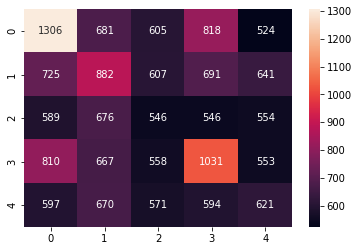

In [ ]:
decision_tree_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(decision_tree_matrix, annot=True, fmt='g')

### Random Forest

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('random_forest', RandomForestClassifier(n_estimators=100))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('random_forest', RandomForestClassifier())])

In [ ]:
filename = 'RandomForest.sav'
pickle.dump(pipe, open(filename, 'wb'))

In [ ]:
pipe.score(test_padded, y_test)

0.2974271816210514

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.35      0.47      0.40      3934
           1       0.26      0.28      0.27      3546
           2       0.25      0.17      0.20      2911
           3       0.32      0.35      0.33      3619
           4       0.25      0.16      0.20      3053

    accuracy                           0.30     17063
   macro avg       0.28      0.28      0.28     17063
weighted avg       0.29      0.30      0.29     17063



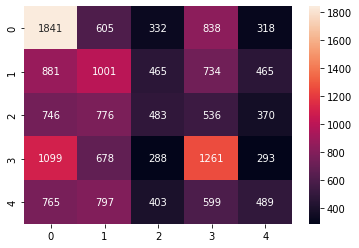

In [ ]:
random_forest_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(random_forest_matrix, annot=True, fmt='g')

### xgboost

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('xg_boost', XGBClassifier(max_depth=3, n_estimators=100, learning_rate=0.1))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('xg_boost', XGBClassifier(objective='multi:softprob'))])

In [ ]:
filename = 'xgboost.sav'
pickle.dump(pipe, open(filename, 'wb'))

In [ ]:
pipe.score(test_padded, y_test)

0.29279728066576804

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.32      0.48      0.38      3934
           1       0.27      0.29      0.28      3546
           2       0.24      0.11      0.15      2911
           3       0.31      0.39      0.34      3619
           4       0.25      0.12      0.16      3053

    accuracy                           0.29     17063
   macro avg       0.28      0.28      0.26     17063
weighted avg       0.28      0.29      0.27     17063



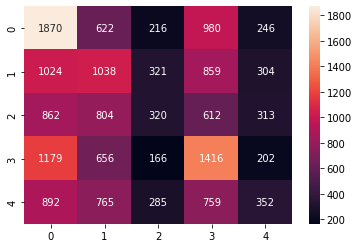

In [ ]:
xg_boost_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(xg_boost_matrix, annot=True, fmt='g')

### Extra Trees

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('extra_trees', ExtraTreesClassifier(n_estimators=100))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('extra_trees', ExtraTreesClassifier())])

In [ ]:
filename = 'ExtraTrees.sav'
pickle.dump(pipe, open(filename, 'wb'))

In [ ]:
pipe.score(test_padded, y_test)

0.29719275625622693

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.34      0.47      0.39      3934
           1       0.27      0.29      0.28      3546
           2       0.23      0.16      0.19      2911
           3       0.33      0.33      0.33      3619
           4       0.26      0.17      0.20      3053

    accuracy                           0.30     17063
   macro avg       0.28      0.28      0.28     17063
weighted avg       0.29      0.30      0.29     17063



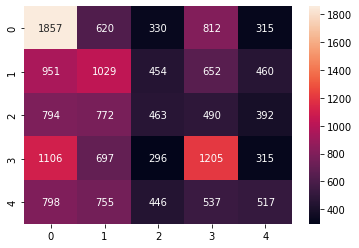

In [ ]:
extra_trees_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(extra_trees_matrix, annot=True, fmt='g')

### Adaboost 

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('ada_boost', AdaBoostClassifier(n_estimators=100))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('ada_boost', AdaBoostClassifier(n_estimators=100))])

In [ ]:
filename = 'AdaBoost.sav'
pickle.dump(pipe, open(filename, 'wb'))

In [ ]:
pipe.score(test_padded, y_test)

0.28218953290746057

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.31      0.47      0.37      3934
           1       0.26      0.26      0.26      3546
           2       0.25      0.12      0.16      2911
           3       0.29      0.36      0.32      3619
           4       0.24      0.13      0.17      3053

    accuracy                           0.28     17063
   macro avg       0.27      0.27      0.26     17063
weighted avg       0.27      0.28      0.27     17063



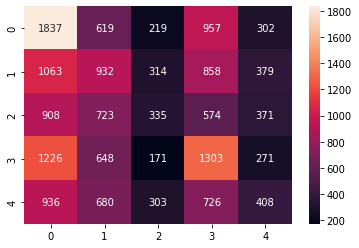

In [ ]:
ada_boost_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(ada_boost_matrix, annot=True, fmt='g')

## Evaluation

**Accuracy scores (GloVe):**

1. Decision Tree: 25.70% (1 min)

2. Random Forest: 29.74% (5 mins)

3. XGBoost: 29.28% (10 mins)

4. Extra-trees: 29.72% (1 min)

5. AdaBoost: 28.22% (5 mins)

#Hyperparameter Tuning

##Automated

In [9]:
# Number of trees in the forest
n_estimators = [50, 100, 300, 500]

# Max number of levels in the tree
max_depth = [5, 8, 15, 25, 30]

# Min number of samples to split internal node
min_samples_split = [2, 5, 10, 15, 100]

# Min number of samples required to be at a leaf node
min_samples_leaf = [1, 2, 5, 10] 

# Create pipeline
pipe = Pipeline([('scaler', MinMaxScaler()), ('random_forest', RandomForestClassifier(random_state = 1))])
print(pipe.get_params())

# Create the parameters dictionary
param_dict = {'random_forest__n_estimators': n_estimators,
              'random_forest__max_depth': max_depth,
              'random_forest__min_samples_split': min_samples_split,
              'random_forest__min_samples_leaf': min_samples_leaf
             }

rf_random = RandomizedSearchCV(estimator = pipe, param_distributions = param_dict, cv = 3, verbose = 3, n_jobs = -1)
best_rf = rf_random.fit(train_padded, y_train)

{'memory': None, 'steps': [('scaler', MinMaxScaler()), ('random_forest', RandomForestClassifier(random_state=1))], 'verbose': False, 'scaler': MinMaxScaler(), 'random_forest': RandomForestClassifier(random_state=1), 'scaler__clip': False, 'scaler__copy': True, 'scaler__feature_range': (0, 1), 'random_forest__bootstrap': True, 'random_forest__ccp_alpha': 0.0, 'random_forest__class_weight': None, 'random_forest__criterion': 'gini', 'random_forest__max_depth': None, 'random_forest__max_features': 'auto', 'random_forest__max_leaf_nodes': None, 'random_forest__max_samples': None, 'random_forest__min_impurity_decrease': 0.0, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2, 'random_forest__min_weight_fraction_leaf': 0.0, 'random_forest__n_estimators': 100, 'random_forest__n_jobs': None, 'random_forest__oob_score': False, 'random_forest__random_state': 1, 'random_forest__verbose': 0, 'random_forest__warm_start': False}
Fitting 3 folds for each of 10 candidates, tota

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [10]:
print("\n The best estimator across all searched params:\n", rf_random.best_estimator_)
print("\n The best score across all searched params:\n", rf_random.best_score_)
print("\n The best parameters across all searched params:\n", rf_random.best_params_)


 The best estimator across all searched params:
 Pipeline(steps=[('scaler', MinMaxScaler()),
                ('random_forest',
                 RandomForestClassifier(max_depth=30, min_samples_leaf=2,
                                        n_estimators=500, random_state=1))])

 The best score across all searched params:
 0.29512170549670197

 The best parameters across all searched params:
 {'random_forest__n_estimators': 500, 'random_forest__min_samples_split': 2, 'random_forest__min_samples_leaf': 2, 'random_forest__max_depth': 30}


##Manual

## Criterion:




### 1. gini (30.59%) (15 mins)

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('random_forest', RandomForestClassifier(n_estimators=300, criterion='gini'))])
pipe.fit(train_padded, y_train)

In [ ]:
pipe.score(test_padded, y_test)

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

In [ ]:
random_forest_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(random_forest_matrix, annot=True, fmt='g')

### 2. entropy (30.71%) (34 mins)

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('random_forest', RandomForestClassifier(n_estimators=300, criterion='entropy'))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('random_forest',
                 RandomForestClassifier(criterion='entropy',
                                        n_estimators=300))])

In [ ]:
pipe.score(test_padded, y_test)

0.30709722792006094

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.35      0.48      0.40      3934
           1       0.27      0.30      0.29      3546
           2       0.27      0.17      0.21      2911
           3       0.33      0.37      0.35      3619
           4       0.25      0.15      0.19      3053

    accuracy                           0.31     17063
   macro avg       0.29      0.29      0.29     17063
weighted avg       0.30      0.31      0.29     17063



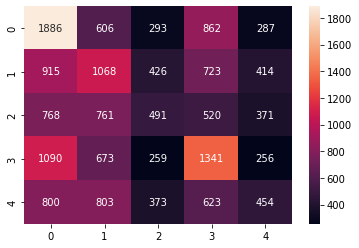

In [ ]:
random_forest_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(random_forest_matrix, annot=True, fmt='g')

## max_features

### None (29.76%) (long time)

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('random_forest', RandomForestClassifier(max_features=None))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('random_forest', RandomForestClassifier(max_features=None))])

In [ ]:
pipe.score(test_padded, y_test)

0.29766160698587585

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.35      0.45      0.40      3934
           1       0.27      0.30      0.29      3546
           2       0.24      0.17      0.20      2911
           3       0.31      0.34      0.33      3619
           4       0.24      0.16      0.19      3053

    accuracy                           0.30     17063
   macro avg       0.28      0.29      0.28     17063
weighted avg       0.29      0.30      0.29     17063



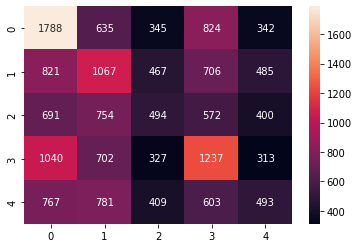

In [ ]:
random_forest_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(random_forest_matrix, annot=True, fmt='g')

### sqrt (29.86%) (5 mins)

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('random_forest', RandomForestClassifier(max_features='sqrt'))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('random_forest', RandomForestClassifier(max_features='sqrt'))])

In [ ]:
pipe.score(test_padded, y_test)

0.2985993084451738

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.34      0.46      0.39      3934
           1       0.26      0.29      0.28      3546
           2       0.24      0.16      0.19      2911
           3       0.32      0.36      0.34      3619
           4       0.26      0.17      0.20      3053

    accuracy                           0.30     17063
   macro avg       0.29      0.29      0.28     17063
weighted avg       0.29      0.30      0.29     17063



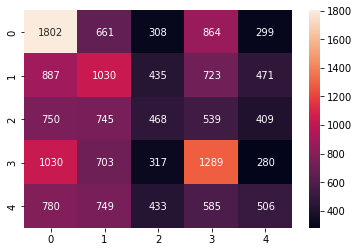

In [ ]:
random_forest_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(random_forest_matrix, annot=True, fmt='g')

### 0.2 (29.61%) (10 mins)

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('random_forest', RandomForestClassifier(max_features=0.2))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('random_forest', RandomForestClassifier(max_features=0.2))])

In [ ]:
pipe.score(test_padded, y_test)

0.29613784211451677

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.35      0.47      0.40      3934
           1       0.25      0.28      0.26      3546
           2       0.25      0.17      0.20      2911
           3       0.32      0.35      0.34      3619
           4       0.24      0.16      0.19      3053

    accuracy                           0.30     17063
   macro avg       0.28      0.28      0.28     17063
weighted avg       0.29      0.30      0.29     17063



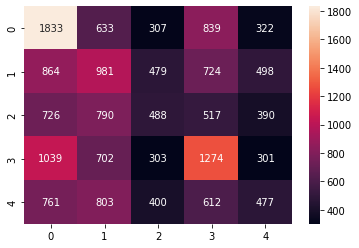

In [ ]:
random_forest_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(random_forest_matrix, annot=True, fmt='g')

### 0.5 (30.17%) (22 mins)

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('random_forest', RandomForestClassifier(max_features=0.5))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('random_forest', RandomForestClassifier(max_features=0.5))])

In [ ]:
pipe.score(test_padded, y_test)

0.30176405087030417

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.35      0.46      0.40      3934
           1       0.26      0.29      0.27      3546
           2       0.25      0.18      0.21      2911
           3       0.33      0.36      0.35      3619
           4       0.24      0.16      0.19      3053

    accuracy                           0.30     17063
   macro avg       0.29      0.29      0.28     17063
weighted avg       0.29      0.30      0.29     17063



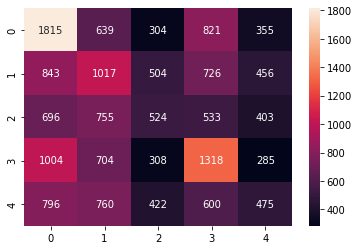

In [ ]:
random_forest_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(random_forest_matrix, annot=True, fmt='g')

### log2 (30.00%) (3 mins)

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('random_forest', RandomForestClassifier(max_features='log2'))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('random_forest', RandomForestClassifier(max_features='log2'))])

In [ ]:
pipe.score(test_padded, y_test)

0.3004747113637696

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.34      0.46      0.39      3934
           1       0.27      0.29      0.28      3546
           2       0.24      0.16      0.19      2911
           3       0.32      0.36      0.34      3619
           4       0.26      0.16      0.20      3053

    accuracy                           0.30     17063
   macro avg       0.29      0.29      0.28     17063
weighted avg       0.29      0.30      0.29     17063



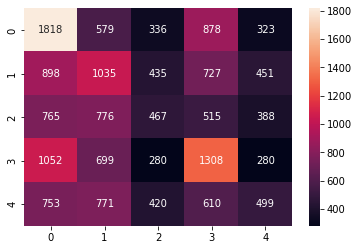

In [ ]:
random_forest_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(random_forest_matrix, annot=True, fmt='g')

## Min samples split

### 2

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('random_forest', RandomForestClassifier(max_features=None, min_samples_split=2))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('random_forest', RandomForestClassifier(max_features=None))])

In [ ]:
pipe.score(test_padded, y_test)

0.30111938111703684

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.35      0.46      0.40      3934
           1       0.27      0.29      0.28      3546
           2       0.25      0.18      0.21      2911
           3       0.32      0.36      0.34      3619
           4       0.25      0.16      0.20      3053

    accuracy                           0.30     17063
   macro avg       0.29      0.29      0.28     17063
weighted avg       0.29      0.30      0.29     17063



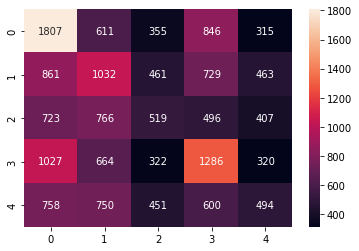

In [ ]:
random_forest_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(random_forest_matrix, annot=True, fmt='g')

## Best

In [ ]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('random_forest', RandomForestClassifier(max_features=0.5, criterion='entropy', n_estimators=300, random_state=42))])
pipe.fit(train_padded, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('random_forest',
                 RandomForestClassifier(criterion='entropy', max_features=0.5,
                                        n_estimators=300, random_state=42))])

In [ ]:
filename = 'RandomForest_glove_tuned.sav'
pickle.dump(pipe, open(filename, 'wb'))

In [ ]:
pipe.score(test_padded, y_test)

0.30698001523764873

In [ ]:
predicted = pipe.predict(test_padded)

In [ ]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.35      0.48      0.41      3934
           1       0.27      0.30      0.29      3546
           2       0.25      0.16      0.19      2911
           3       0.33      0.37      0.35      3619
           4       0.26      0.16      0.20      3053

    accuracy                           0.31     17063
   macro avg       0.29      0.29      0.29     17063
weighted avg       0.30      0.31      0.30     17063



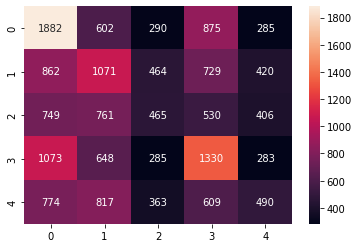

In [ ]:
random_forest_matrix = confusion_matrix(y_test,predicted)  
sb.heatmap(random_forest_matrix, annot=True, fmt='g')